# Generative Adversarial Networks (GANs)

In this homework, you will be working with GANs.

In [ ]:
%matplotlib inline
import torch
import torch.utils.data
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt

from torchvision.models.inception import inception_v3
from torchvision import datasets, transforms
from scipy.stats import entropy
import copy

import itertools

torch.manual_seed(0); #you may want to make use of this in various cells for reproducability
gpu_boole = torch.cuda.is_available()

## 1. Introduction and Motivation

As a recap from lecture:

GANs are a popular architecture class for
generating data. They were first introduced in (Goodfellow et al 2014). 

The two major components of a GAN framework are a Discriminator network $D$ and
a Generator network $G$.

$D$ takes a data sample as input and decides whether it is real (coming from the actual 
training set) or fake (generated artificially). $G$ takes some random noise vector
$z$ as input and outputs a generated sample. 

In practice, these networks "battle": $G$ continually attmepts to generate
more realistic samples and $D$ continually tries to get better at distinguishing
real samples from fake smaples. This can be formulated as a min-max zero sum game:

$$\min_G \max_D V(D, G) = \mathbb{E}_{x \sim p_{data}(x)} [\log D(x)] + \mathbb{E}_{z \sim p_z(z)} [\log (1 - D(G(z))]$$
where $p_z(z)$ denotes a defined prior over the noise vector. Local and global minima for this problem exist at local and global Nash Equilibria.

The hope is that, over training, $D$ becomes a very good discriminator and $G$ becomes
a very good generator. At the end of training, we can then make use of $G$
to generate nice looking samples that seem like they were drawn from the original
distribution.

## 2. Experiments on MNIST

Now we move on to MNIST experiments.

### 2.1. Inception Score

Rather than just eye-balling whether GAN samples look good or not,
researchers have come up with objective metrics for determining the quality
and breadth of GAN outputs. One such metric is called the inception score (IS),
which we will be using, although it is not without its drawbacks. It can be implemented in multiple ways. The higher the inception score, the better our GAN model is.

A detailed and thorough explanation of IS can be found at multiple sources.  For example, you can read more about it [here](https://medium.com/octavian-ai/a-simple-explanation-of-the-inception-score-372dff6a8c7a). Roughly stated, for a dataset with a given number of classes, high inception scores correspond to GAN samples that have low intra-class entropy and high inter-class entropy.

To make your life easier, we provide the implementation of IS score for you.

In [ ]:
def MNIST_IS(imgs, model_path='MNIST.ckpt', batch_size=32, splits=10):
    
    """Computes the inception score of the generated images imgs
    params: 
    imgs : numpy array of dimension (# of datapoints, 1, 28, 28)
    batch_size : batch size for feeding into the pretrained MNIST model
    splits : number of splits
    """
    N = len(imgs)
    
    #check imgs is numpy array & of desired dimension
    assert type(imgs) is np.ndarray
    assert imgs.shape[1] == 1
    assert imgs.shape[2] == 28
    assert imgs.shape[3] == 28
    assert batch_size > 0
    assert N > batch_size
    
    imgs = copy.copy(imgs)
    
    # Set up dtype
    if torch.cuda.is_available():
        dtype = torch.cuda.FloatTensor
    else:
        dtype = torch.FloatTensor
    
    MEAN = 0.1307
    STD = 0.3081
    imgs -= MEAN
    imgs /= STD
    
    # Set up dataloader
    dataloader = torch.utils.data.DataLoader(imgs, batch_size=batch_size)

    # Load inception model
    MNIST_model = ConvNet()
    MNIST_model.load_state_dict(torch.load(model_path))
    if torch.cuda.is_available():
        MNIST_model = MNIST_model.cuda()
    MNIST_model.eval()

    def get_pred(x):
        if torch.cuda.is_available():
            x = x.cuda()
        x = MNIST_model(x)
        return F.softmax(x, dim=0).data.cpu().numpy()

    # Get predictions
    preds = np.zeros((N, 10))

    for i, batch in enumerate(dataloader, 0):
        batch = batch.type(dtype)
        batch_size_i = batch.size()[0]

        preds[i*batch_size:i*batch_size + batch_size_i] = get_pred(batch)

    # Now compute the mean kl-div
    split_scores = []

    for k in range(splits):
        part = preds[k * (N // splits): (k+1) * (N // splits), :]
        py = np.mean(part, axis=0)
        scores = []
        for i in range(part.shape[0]):
            pyx = part[i, :]
            scores.append(entropy(pyx, py))
        split_scores.append(np.exp(np.mean(scores)))
    
    return np.mean(split_scores), np.std(split_scores)

#Model structure of the pretrained MNIST data
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.drop_out = nn.Dropout()
        self.fc1 = nn.Linear(7 * 7 * 64, 1000)
        self.fc2 = nn.Linear(1000, 10)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.drop_out(out)
        out = self.fc1(out)
        out = self.fc2(out)
        return out


Now, let's see the inception score for the actual MNIST dataset.

First, let's load a copy of MNIST.ckpt into the Colaboratory space.

In [ ]:
try:
    import requests
except ImportError:
    !pip install requests
    import requests

def download_file_from_google_drive(id, destination):
    URL = "https://docs.google.com/uc?export=download"

    session = requests.Session()

    response = session.get(URL, params = { 'id' : id }, stream = True)
    token = get_confirm_token(response)

    if token:
        params = { 'id' : id, 'confirm' : token }
        response = session.get(URL, params = params, stream = True)

    save_response_content(response, destination)    

def get_confirm_token(response):
    for key, value in response.cookies.items():
        if key.startswith('download_warning'):
            return value

    return None

def save_response_content(response, destination):
    CHUNK_SIZE = 32768

    with open(destination, "wb") as f:
        for chunk in response.iter_content(CHUNK_SIZE):
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)

file_id = '1j5O8LKuSxXbDYaGptBxqDH3YqYYpK4tK'
destination = 'MNIST.ckpt'
download_file_from_google_drive(file_id, destination)

In [ ]:
transform = transforms.ToTensor()
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data', train=True, download=True, transform=transform),
    batch_size=500, shuffle=True)

for x, y in train_loader:
    x = x
    break
x = x.cpu().data.numpy()
x = x.reshape([-1,1,28,28])
print('Shape of data:',x.shape)
mis = MNIST_IS(x)
print('Inception Score:','mean:',mis[0],'std:',mis[1])

Shape of data: (500, 1, 28, 28)
Inception Score: mean: 8.672265197296719 std: 1.0868051719198717


The score for MNIST should be somewhere around 8 to 12. As we train our GAN(s), we will be looking to
get as high an inception score as possible on our generated images.


### 2.2. Generating MNIST images


#### Deliverables

Given the limited computational resources, you will want to achieve an inception score of 1.5 or greater for full credit. An IS of 1.5 won't yield good images. For okay-looking images, you'll need an IS of at least 2. For nice looking images, you'll need an inception score of around 6.0, but it is not needed for full credit.

Scores above 1.5 will receive bonus points.

#### Instructions for long training times

For more complicated architectures, if your model takes a long time to train, you will need to save the model and write a code snippet that loads it such that your notebook runs with no errors. In this case, set epochs = 0 and include the saved model in your submission on Gradescope (or a Google drive link / something similar if it is too large for Gradescope).

#### Some Optional Tips

It will be easier to get better results with a convolutional GAN as MLPs are typically not used in practical settings. Deconvolutional layers (implemented via `nn.ConvTranspose2d` in pytorch) are typically used. I suggest paying attention to the shapes at each line of the forward pass to avoid errors.

There are additional GAN architectures online you may want to reference for inspiration. (But do not plagiarize -- please write your own custom network.)

### 2.2.1. Define your generator
Your can start with a generator with four Deconvolutional layers, and each layer is followed by a batch norm layer. Use Relu as the activation function for intermediate layers, and tanh for the output layer.

The out_channels, kernel_size, stride, padding, for each layer is (16, 4, 1, 1), (8, 4, 2, 0), (4, 4, 2, 0), (1, 4, 2, 1).

In [ ]:
#TODO Defining your networks:

class generator(nn.Module):
    # initializers
    def __init__(self, input_channel):
        super(generator, self).__init__()
        #TODO
        self.layers = nn.Sequential(
          nn.ConvTranspose2d(in_channels=input_channel, out_channels=16, kernel_size=4, stride=2, padding=1, bias=True),
          nn.BatchNorm2d(16),
          nn.ReLU(),
          nn.ConvTranspose2d(in_channels=16, out_channels=8, kernel_size=4, stride=2, padding=0, bias=True),
          nn.BatchNorm2d(8),
          nn.ReLU(),
          nn.ConvTranspose2d(in_channels=8, out_channels=4, kernel_size=4, stride=2, padding=0, bias=True),
          nn.BatchNorm2d(4),
          nn.ReLU(),
          nn.ConvTranspose2d(in_channels=4, out_channels=1, kernel_size=4, stride=2, padding=1, bias=True),
          nn.BatchNorm2d(1),
          nn.Tanh()
        )

    # weight_init
    def weight_init(self, mean, std):
        for m in self._modules:
            normal_init(self._modules[m], mean, std)

    # forward method
    def forward(self, input):
        #TODO
        x = self.layers(input)
        return x

### 2.2.1. Define your discriminator
Your can start with a discriminator with four convolutional layers, the second and the third layer are followed by one batch norm layer. Use LeakyReLU with negative slope 0.2 as the activation function for intermediate layers, and sigmoid for the output layer.

The out_channels, kernel_size, stride, padding, for each layer is (2, 4, 2, 1), (4, 4, 2, 1), (8, 4, 2, 1), (1, 4, 2, 1). 

In [ ]:
class discriminator(nn.Module):
    # initializers
    def __init__(self):
        super(discriminator, self).__init__()
        #TODO
        self.layers = nn.Sequential(
          nn.Conv2d(in_channels=1, out_channels=2, kernel_size=4, stride=2, padding=1, bias=True),
          nn.LeakyReLU(0.2),
          nn.Conv2d(in_channels=2, out_channels=4, kernel_size=4, stride=2, padding=1, bias=True),
          nn.BatchNorm2d(4),
          nn.LeakyReLU(0.2),
          nn.Conv2d(in_channels=4, out_channels=8, kernel_size=4, stride=2, padding=1, bias=True),
          nn.BatchNorm2d(8),
          nn.LeakyReLU(0.2),
          nn.Conv2d(in_channels=8, out_channels=1, kernel_size=4, stride=2, padding=1, bias=True),
          nn.Sigmoid()
        )

    # weight_init
    def weight_init(self, mean, std):
        for m in self._modules:
            normal_init(self._modules[m], mean, std)

    # forward method
    def forward(self, input):
        #TODO
        x = self.layers(input)
        return x   

### 2.3. Training the GAN

Now, we will set up the $D, G$ training regime. We iterate over our training
set. For each batch:

1. For the discriminator, push $D$ towards identifying each sample in the batch with probability close to 1. We then generate an equal number of artificial samples with $G$ and push $D$ towards identifying each sample in the batch with probability close to 0 (i.e. identifying it as a fake sample). Both of these are done by minimizing BCE loss.
2. For $G$, we will take another random batch of artificial samples and update $G$ in such a way that we push $D$ towards identifying the artificial samples as real. This can also be done by minimizing BCE loss.


Training starts!

Epoch: 1 of 15
[1/15] - loss_d: 0.757, loss_g: 2.845
Inception Score: mean: 1.5741641747346884 std: 0.04724760552103045
Epoch: 2 of 15
[2/15] - loss_d: 0.745, loss_g: 2.860
Inception Score: mean: 1.894743388610817 std: 0.0756274408561384
Epoch: 3 of 15
[3/15] - loss_d: 0.740, loss_g: 2.948
Inception Score: mean: 1.545505948566024 std: 0.03289292402448812
Epoch: 4 of 15
[4/15] - loss_d: 0.738, loss_g: 3.030
Inception Score: mean: 1.7707942314502467 std: 0.05201963942772583
Epoch: 5 of 15
[5/15] - loss_d: 0.744, loss_g: 3.032
Inception Score: mean: 1.8633829959917452 std: 0.05596657719283746
Epoch: 6 of 15
[6/15] - loss_d: 0.747, loss_g: 3.009
Inception Score: mean: 1.6482335518912552 std: 0.046354895410567414
Epoch: 7 of 15
[7/15] - loss_d: 0.768, loss_g: 2.931
Inception Score: mean: 1.6119584329078662 std: 0.05647668790037506
Epoch: 8 of 15
[8/15] - loss_d: 0.788, loss_g: 2.822
Inception Score: mean: 1.67345123403869 std: 0.08907580688125909
Early Stop.
Training ends!

Text(0, 0.5, 'Loss')

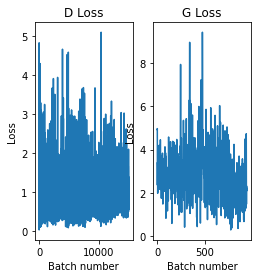

In [ ]:
#Training code:

gpu_boole = torch.cuda.is_available()
cnn_boole = True #set True for CNN reshaping

#TODO tune the hyper parameter carefully to achieve a nash equilibrium
#The initial hyper parameters are not ideal, you need to tune them to make things work.
k = 10 
epochs = 15
batch_size = 32 
lr_g = 0.2
lr_d = 0.2
train_interval = 15

G = generator(k)
D = discriminator()

if gpu_boole:
    G = G.cuda()
    D = D.cuda()
    
#data loader:
transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5])
#        transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data', train=True, download=True, transform=transform),
    batch_size=batch_size, shuffle=True)

#D,G optimizers:
G_optimizer = optim.SGD(G.parameters(), lr=lr_g)
D_optimizer = optim.SGD(D.parameters(), lr=lr_d)

#loss definition(s):
BCE_loss = nn.BCELoss()

#training loop:
D_real_losses = []
D_losses = []
G_losses = []
print("Training starts!")
print()
for epoch in range(epochs):
    count = 0
    print("Epoch:", epoch+1, "of", epochs)
    for x_, _ in train_loader:
        
        #reshaping depending on your architecture class:
        if not cnn_boole:
            x_ = x_.view(batch_size,-1) #this reshape is needed for MLP class
        if gpu_boole:
            x_ = x_.cuda()
        
        mini_batch = x_.size()[0]
        y_real_ = torch.ones(mini_batch)
        y_fake_ = torch.zeros(mini_batch)
        if gpu_boole:
            y_real_ = y_real_.cuda()
            y_fake_ = y_fake_.cuda()
        z_ = torch.randn((mini_batch, k))
        if cnn_boole:
            z_ = z_.view(-1, k, 1, 1) #needed for CNN        
        if gpu_boole:
            z_ = z_.cuda()

        # TODO train discriminator D
        # Step 1 get prediction of D on real data x_ and calculate D_real_loss for real data 
        real_output = D(x_).view(mini_batch)
        D_real_loss = BCE_loss(real_output, y_real_)
        D_real_losses.append(D_real_loss.item())

        # Step 2 get prediction of D on fake data generated by generator based on z_
        # and calculate D_fake_loss for fake data
        fake_output = D(G(z_)).view(mini_batch)
        D_fake_loss = BCE_loss(fake_output, y_fake_)

        # Step 3 calculate the overall loss for D and update weight. (we've done this for you)
        D_train_loss = D_real_loss + D_fake_loss
        D.zero_grad()
        D_train_loss.backward()
        D_optimizer.step()
        D_losses.append(D_train_loss.data.item())

        # TODO train generator G
        # Step 0 think about the collapse problem we mentioned in lectures
        # and how we deal with that. The hyperparameter train_interval might help.
        if count < train_interval:
          count += 1
          continue
        count = 0

        # Step 1 calculate a new z_ and get prediction of fake data generated by 
        # generator based on z_
        fake_output = D(G(z_)).view(mini_batch)
        G_train_loss = BCE_loss(fake_output, y_real_)
        
        # Step 2 calculate the train loss for generator and update weight (we've done this for you)
        G.zero_grad()
        G_train_loss.backward()
        G_optimizer.step()
        G_losses.append(G_train_loss.data.item())

    print('[%d/%d] - loss_d: %.3f, loss_g: %.3f' % ((epoch + 1), epochs, torch.mean(torch.FloatTensor(D_losses)), torch.mean(torch.FloatTensor(G_losses))))
    
    # Samples from G:
    z_ = torch.randn((1500, k))
    if gpu_boole:
        z_ = z_.cuda()
    if cnn_boole:
        z_ = z_.view(-1, k, 1, 1) #needed for CNN        
        
    G_result = G(z_)
    G_result = G_result.cpu().data.numpy()
    G_result = G_result.reshape([1500,1,28,28])

    mis = MNIST_IS(G_result)
    print('Inception Score:','mean:',mis[0],'std:',mis[1])
    if mis[0] > 1.65 and epoch > 5:
      print("Early Stop.")
      break

print("Training ends!")

#Plotting:

#Losses:
plt.subplot(1, 3, 1)
plt.plot(D_losses)
plt.title("D Loss")
plt.xlabel("Batch number")
plt.ylabel("Loss")
plt.subplot(1, 3, 2)
plt.plot(G_losses)
plt.title("G Loss")
plt.xlabel("Batch number")
plt.ylabel("Loss")

##### Computing inception score:

In [ ]:
# Samples from G:
z_ = torch.randn((1500, k))
if gpu_boole:
    z_ = z_.cuda()
if cnn_boole:
    z_ = z_.view(-1, k, 1, 1) #needed for CNN        
    
G_result = G(z_)
G_result = G_result.cpu().data.numpy()
G_result = G_result.reshape([1500,1,28,28])

mis = MNIST_IS(G_result)
print('Inception Score:','mean:',mis[0],'std:',mis[1])

Inception Score: mean: 1.6671826139542858 std: 0.03021202365753506


##### Visualizing GAN samples

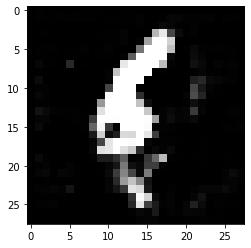

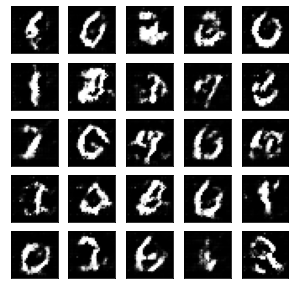

In [ ]:
# Samples from G:
z_ = torch.randn((1500, k))
if gpu_boole:
    z_ = z_.cuda()
if cnn_boole:
    z_ = z_.view(-1, k, 1, 1) #needed for CNN        

G_result = G(z_)
G_result = G_result.cpu().data.numpy()
G_result = G_result.reshape([1500,28,28])

plt.imshow(G_result[0],cmap='gray')

size_figure_grid = 5
fig, ax = plt.subplots(size_figure_grid, size_figure_grid, figsize=(5, 5))
for i, j in itertools.product(range(size_figure_grid), range(size_figure_grid)):
    ax[i, j].get_xaxis().set_visible(False)
    ax[i, j].get_yaxis().set_visible(False)

for kr in range(5*5):
    i = kr // 5
    j = kr % 5
    ax[i, j].cla()
    ax[i, j].imshow(G_result[kr], cmap='gray')
